In [1]:
%load_ext autoreload
%autoreload 2

08:34:07 - INFO: Sampling 4 new images....
699it [01:04, 10.82it/s]


0.00392156862745098
0.050980392156862744
0.027450980392156862
0.00784313725490196


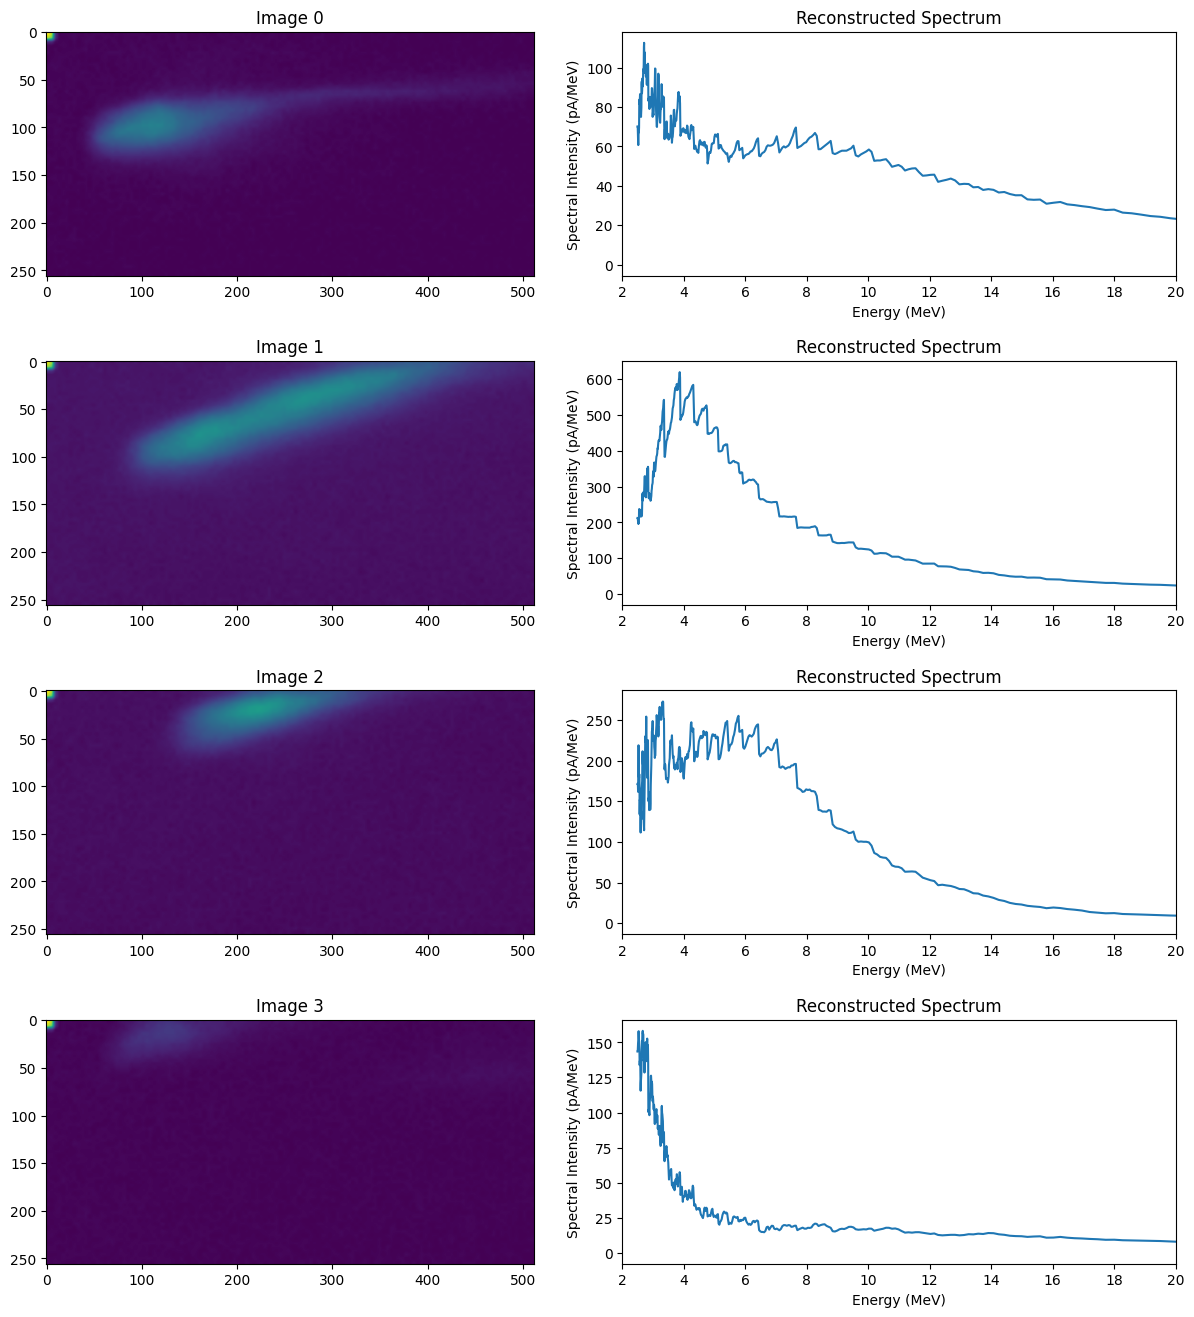

In [3]:
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir, plot_image_pairs

n = 4
device = "cuda:1"
E = 25
P = 35
ms = 30
model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/transfer_withgain_512/ema_ckpt.pt")
# ckpt = torch.load("models/transfer_specific_batchbigger/ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_width=128, img_height=64, device=device, noise_steps=700)
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = diffusion.sample(model, n, y, cfg_scale=3, resize=[256, 512])
# print(x)
plot_image_pairs(x, xlim=[2,20], electron_pointing_pixel=62)
# plot_images(x)
# save_samples(x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.0
0.01568627450980392
0.0
0.09411764705882353


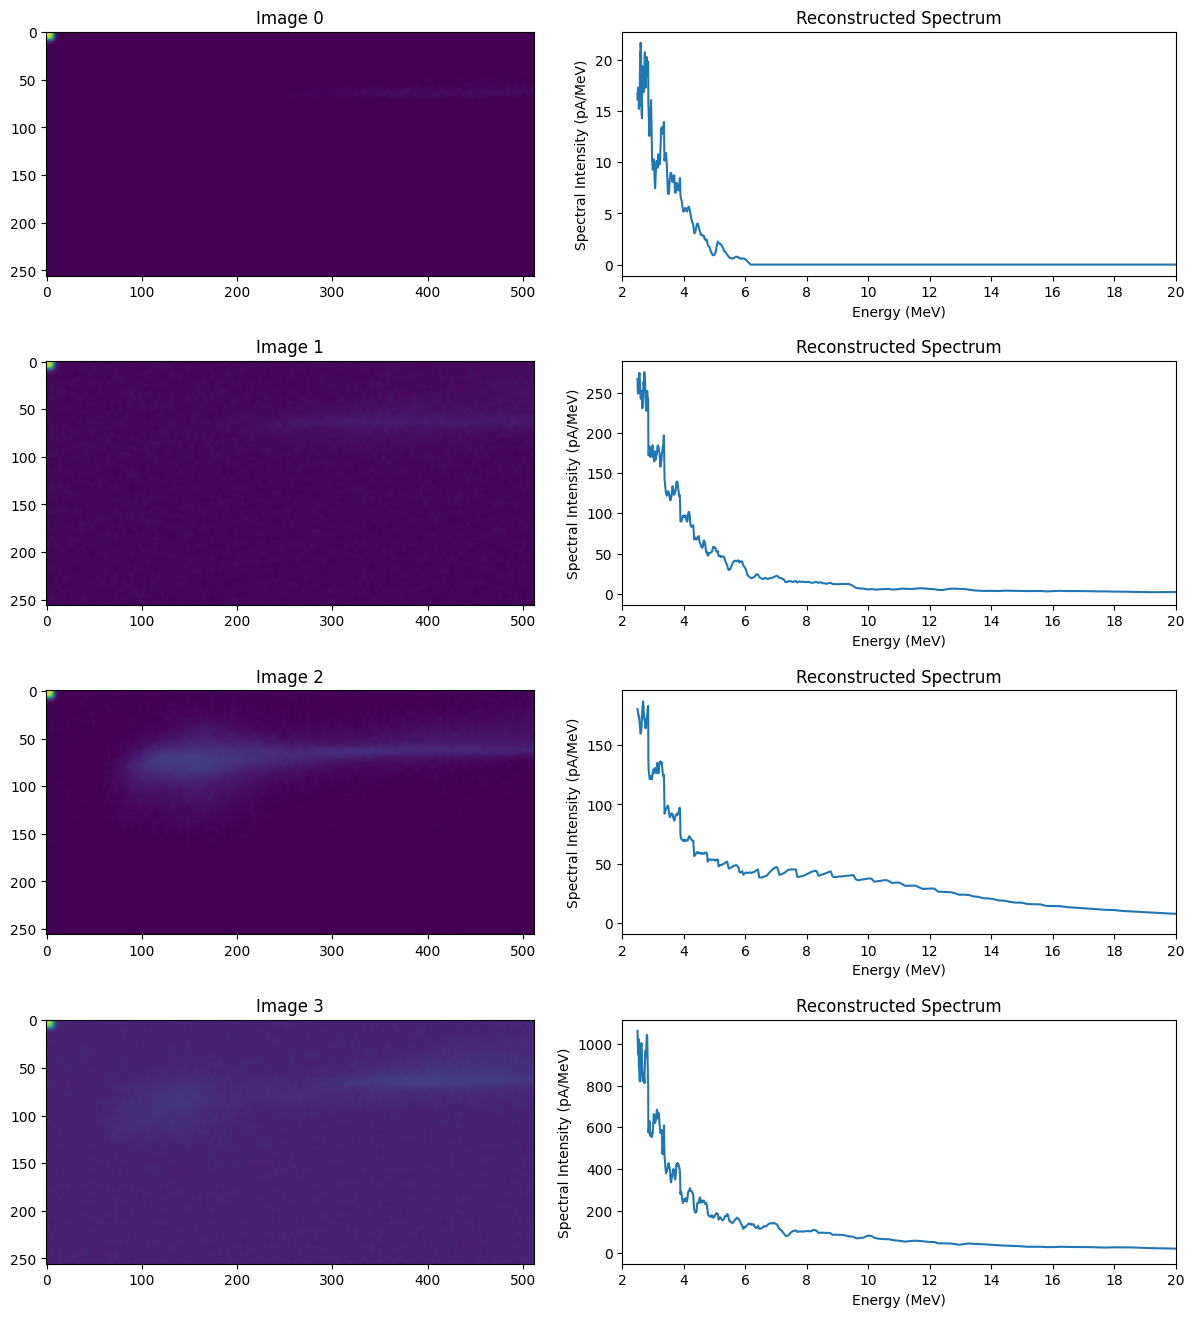

In [40]:
%load_ext autoreload
%autoreload 2
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir, plot_image_pairs
plot_image_pairs(x, xlim=[2,20], electron_pointing_pixel=62)

  1%|          | 3/300 [00:00<00:43,  6.82it/s]

100%|██████████| 300/300 [00:50<00:00,  5.91it/s]


[230, 25, 230, 460, 25, 460]
0.0
[230, 25, 230, 460, 25, 460]
0.0
[230, 25, 230, 460, 25, 460]
0.08235294117647059
[230, 25, 230, 460, 25, 460]
0.01568627450980392
[230, 25, 230, 460, 25, 460]
0.0
[230, 25, 230, 460, 25, 460]
0.0
[230, 25, 230, 460, 25, 460]
0.0
[230, 25, 230, 460, 25, 460]
0.01568627450980392


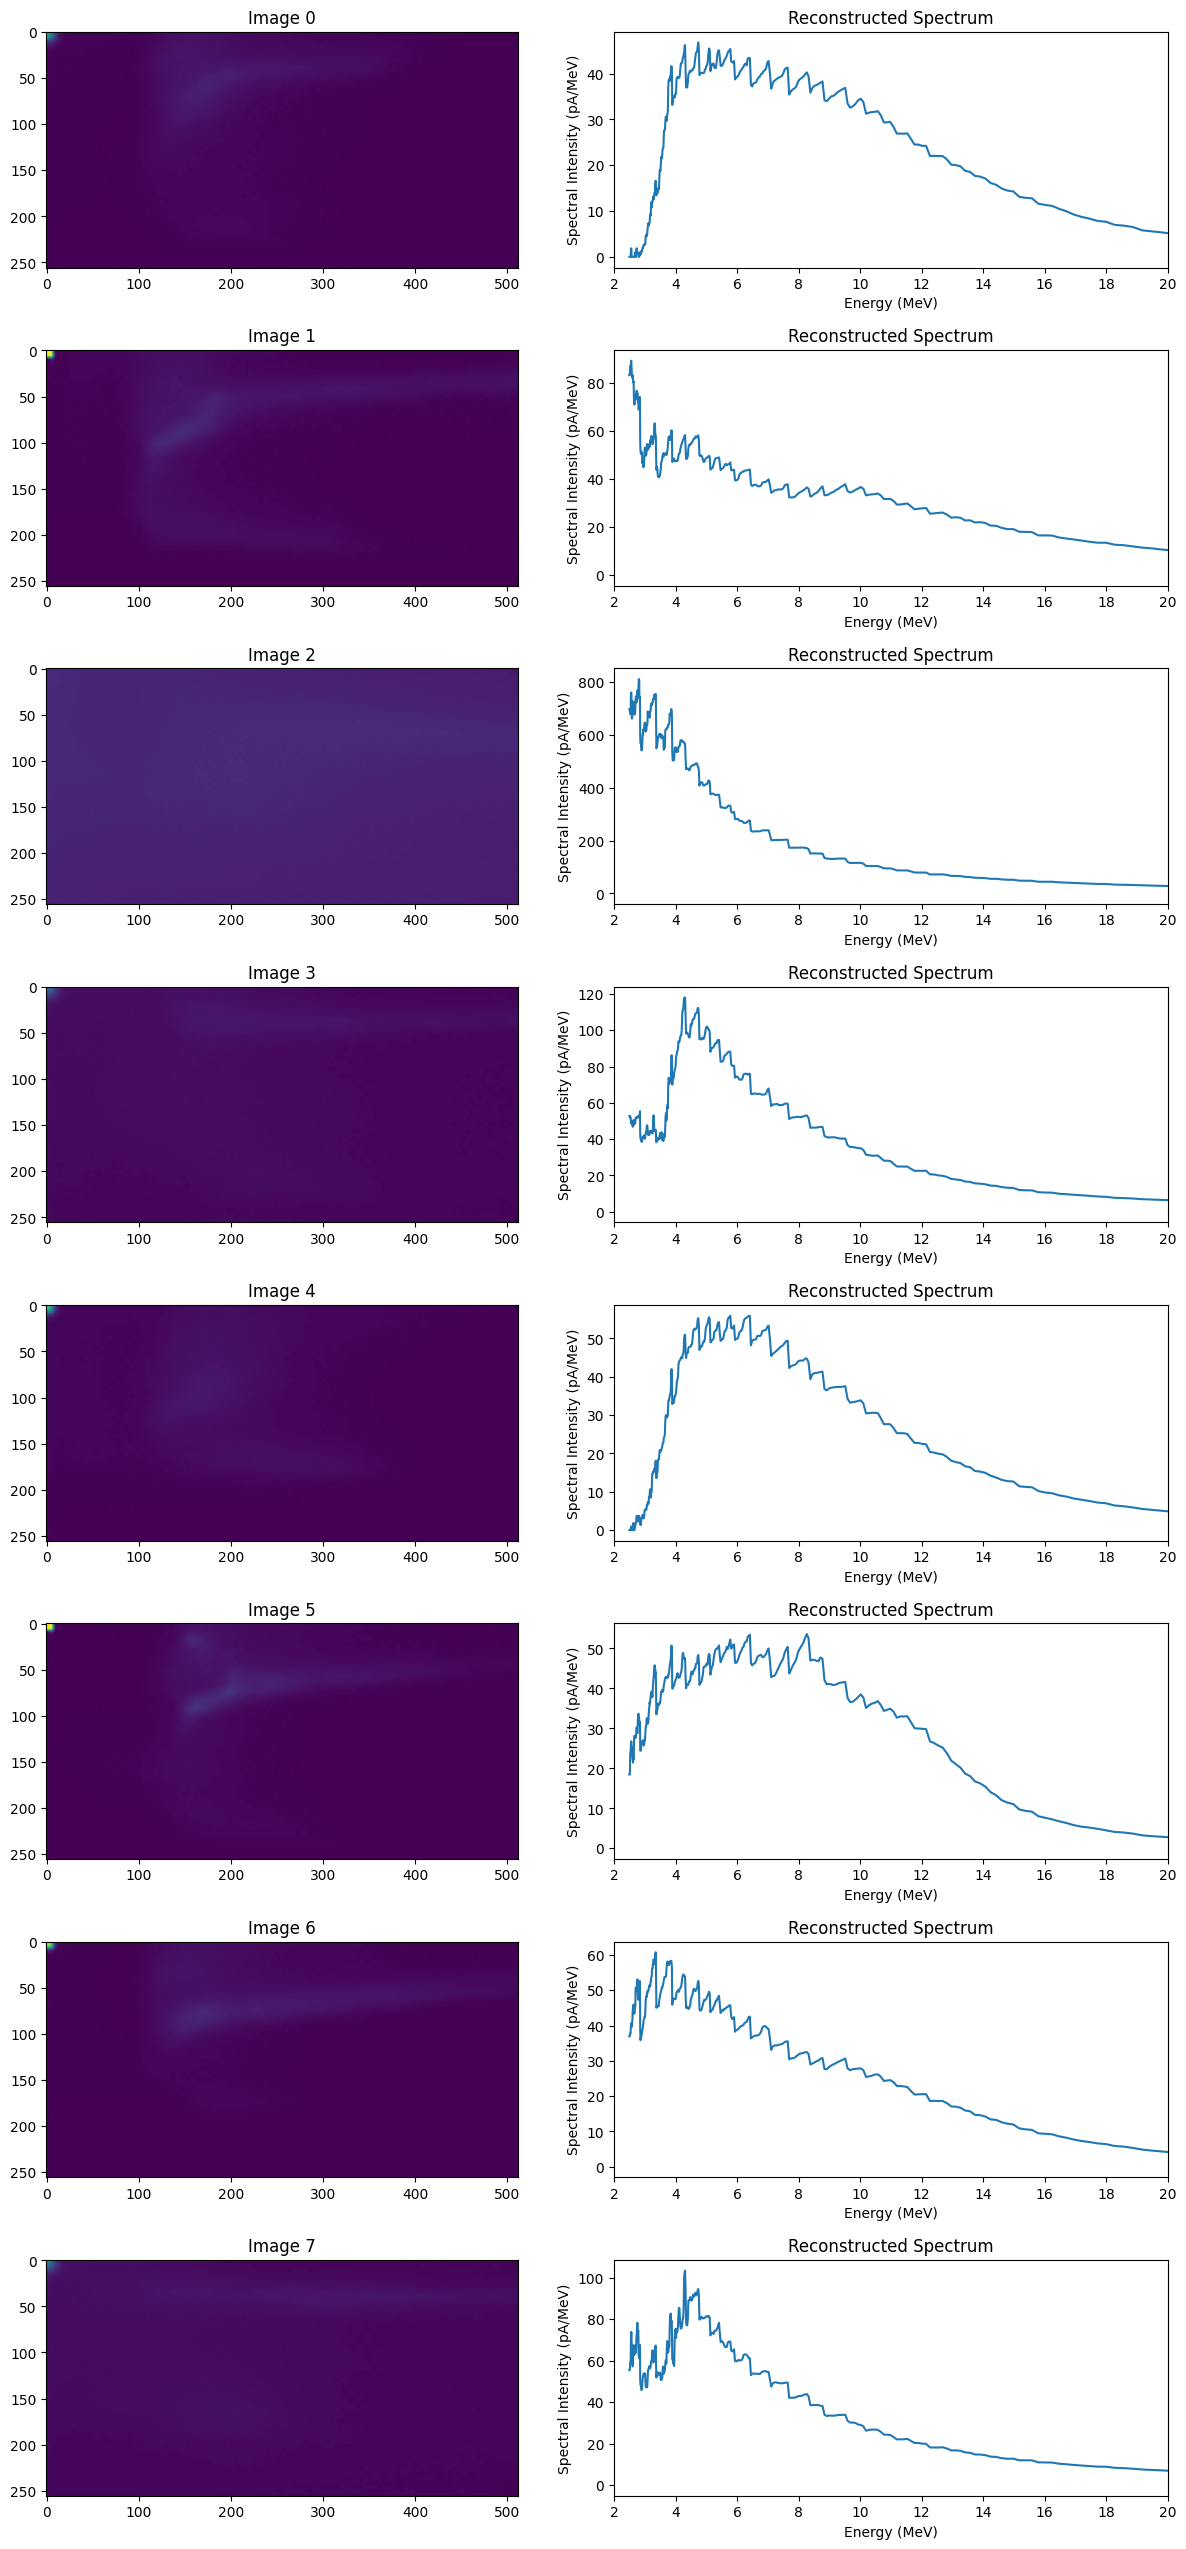

In [5]:
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir, plot_image_pairs
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.batch_size = 8
args.image_height = 64
args.image_width = 128
args.features = ["E","P","ms"]
args.dataset_path = r"with_gain"
args.csv_path = "params.csv"
args.exclude = []# ['train/19']
delta = 0.0125
blur_sigma_max = 128
blur_sigma_min = 0.5

n = 4
device = "cuda:0"
model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/IHD_with_gain/ema_ckpt.pt")
# ckpt = torch.load("models/transfer_specific_batchbigger/ema_ckpt.pt")
model.load_state_dict(ckpt)
model.eval()
diffusion = DCTBlur(img_width=128, img_height=64, device=device, noise_steps=300)
diffusion.prepare_blur_schedule(blur_sigma_max, blur_sigma_min)
y = torch.Tensor([26,10.5,10]).to(device).float().unsqueeze(0) # parameter vector
x = diffusion.sample(trainloader=get_data(args), device=device, model=model, delta=delta, settings=y, resize=(256, 512))
# print(x)
plot_image_pairs(x, xlim=[2,20], electron_pointing_pixel=62)
# plot_images(x)
# save_samples(x)

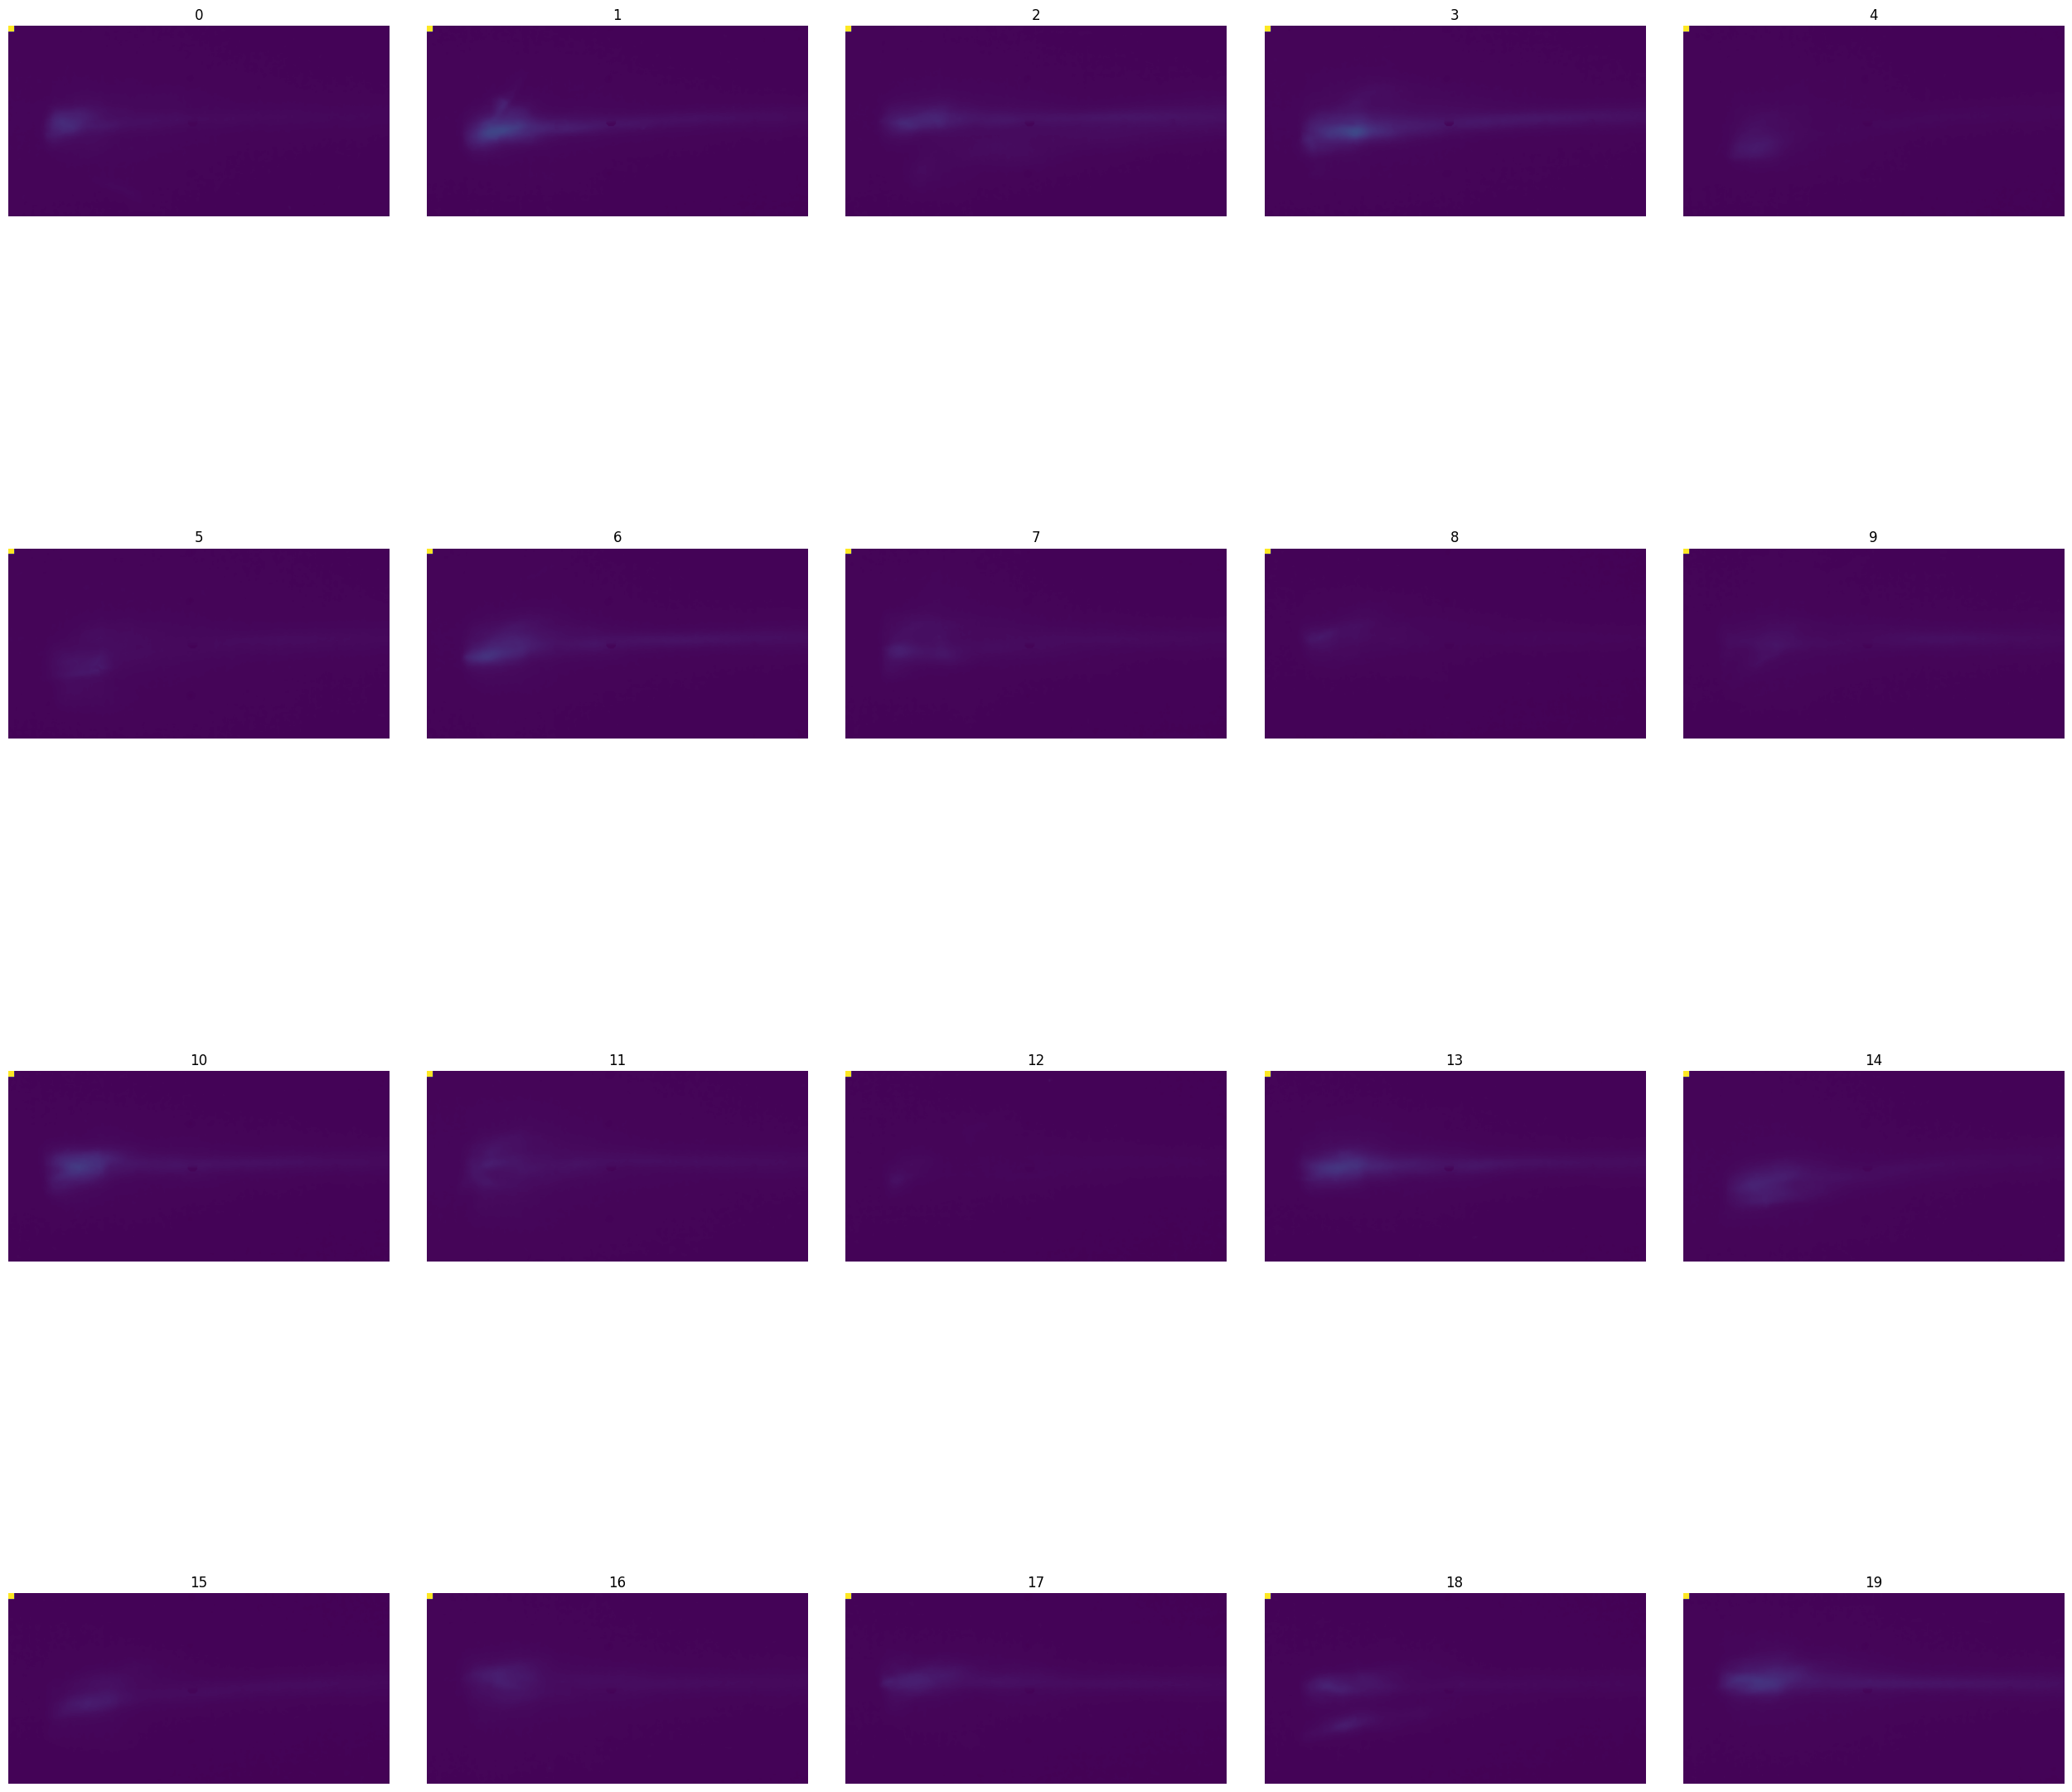

In [8]:
plot_images_from_dir("with_gain/19", 20)